Using device: cpu
Medical Image Classification with PyTorch
Setting up real data...
Extracting images...
Found 8021 files in zip


Extracting images: 100%|██████████| 8021/8021 [00:17<00:00, 455.95it/s]


✓ Found 4009 images in: data_sample
✓ Extraction completed

Analyzing dataset...
Dataset loaded with 220025 images


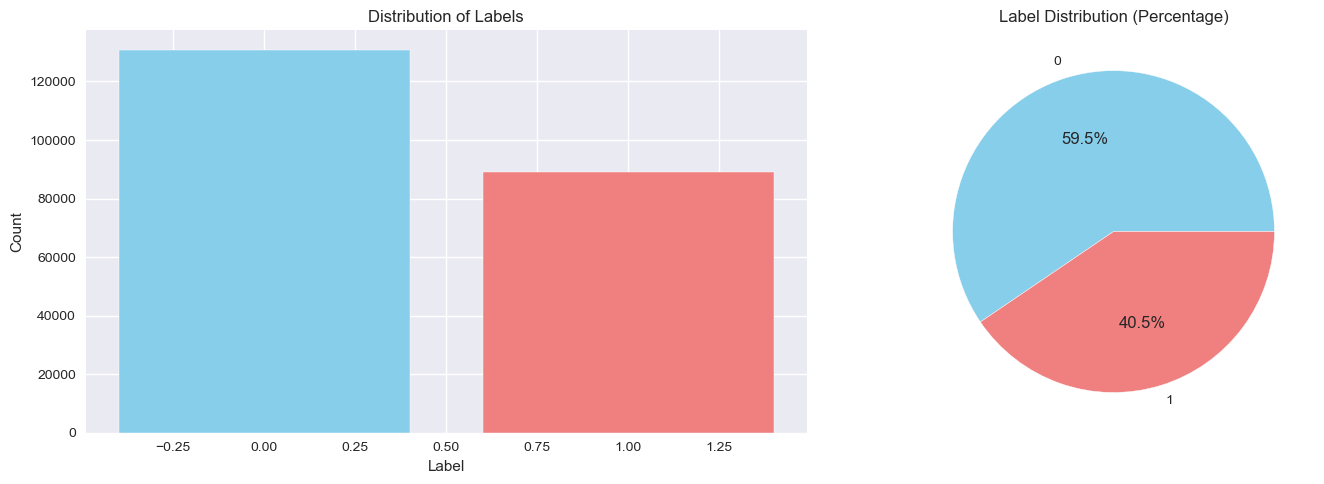

Dataset Statistics:
Total images: 220025
Label distribution:
label
0    130908
1     89117
Name: count, dtype: int64
Class balance ratio: 0.68
Loaded train dataset with 2806 images from ./data_sample
Loaded val dataset with 601 images from ./data_sample
Loaded test dataset with 602 images from ./data_sample

Visualizing sample images...


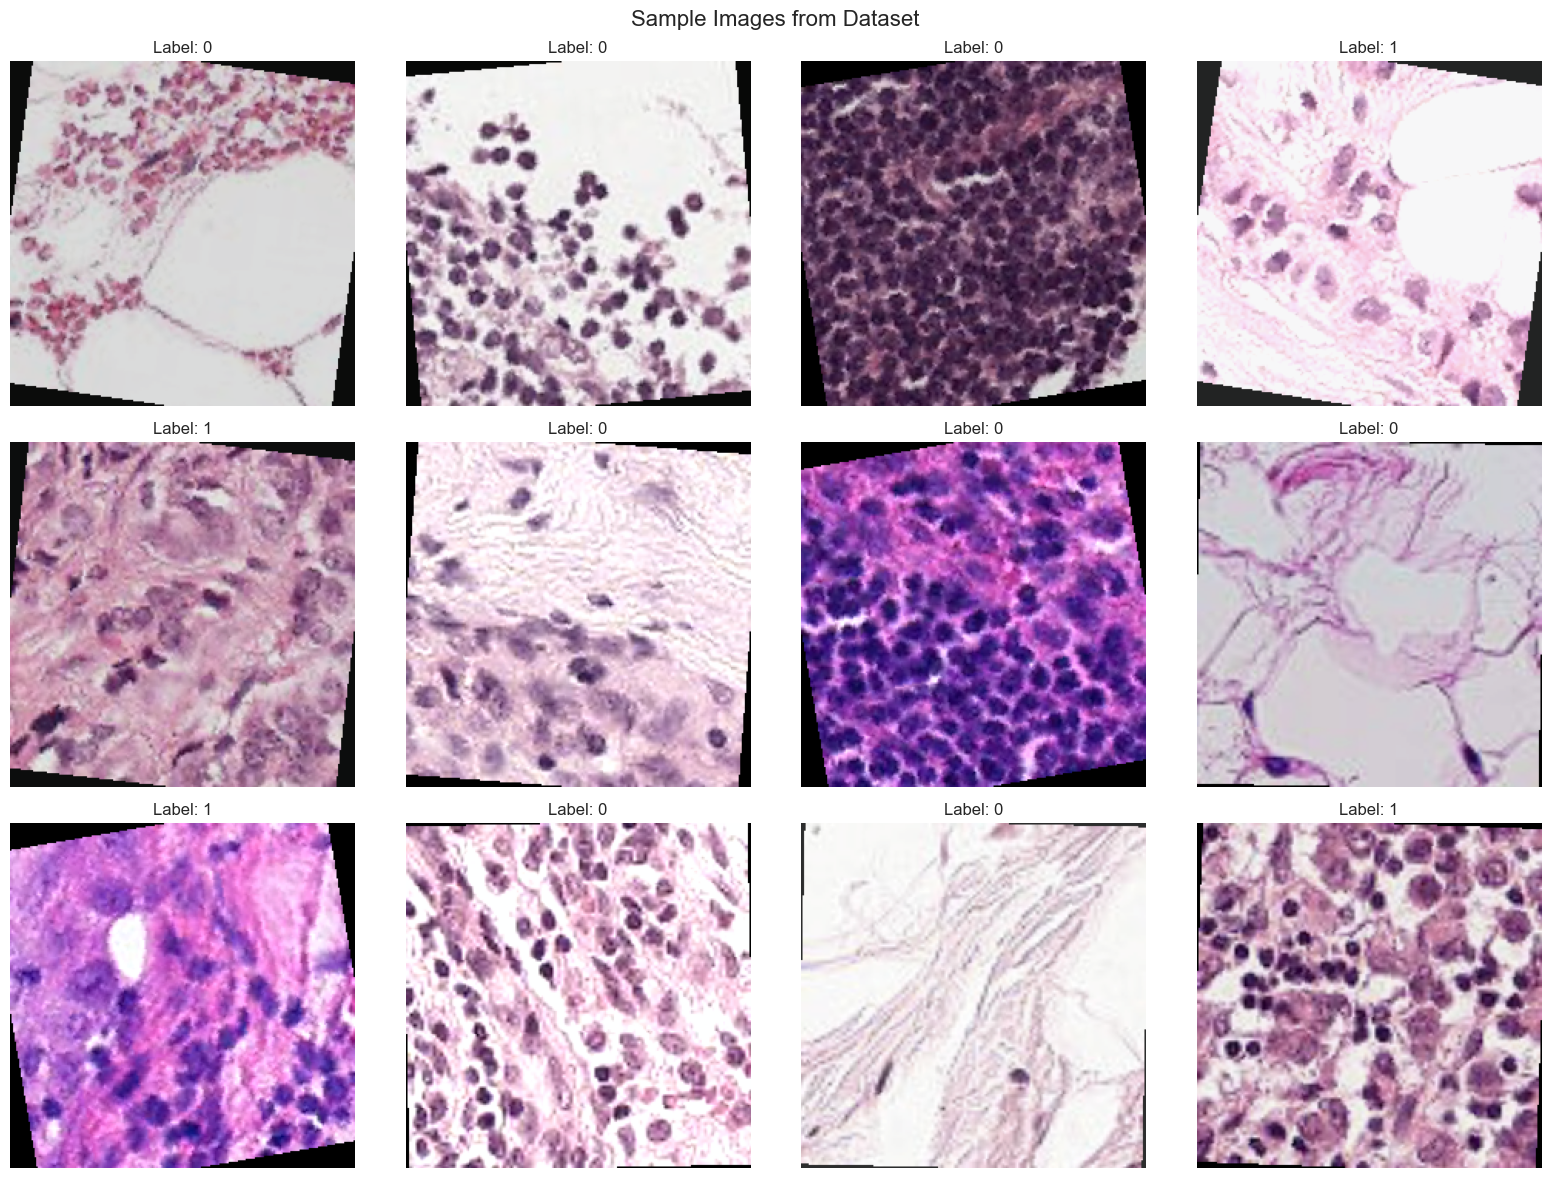


Creating model...
Model created with 65922 trainable parameters

Training model for 10 epochs...


Epoch 1/10 [Train]: 100%|██████████| 88/88 [06:20<00:00,  4.32s/it, Loss=0.5923, Acc=68.78%]


Epoch 1/10:
Train Loss: 0.5923, Train Acc: 68.78%
Val Loss: 0.4433, Val Acc: 82.86%
--------------------------------------------------


Epoch 2/10 [Train]: 100%|██████████| 88/88 [05:57<00:00,  4.06s/it, Loss=0.5121, Acc=74.91%]


Epoch 2/10:
Train Loss: 0.5121, Train Acc: 74.91%
Val Loss: 0.4084, Val Acc: 83.36%
--------------------------------------------------


Epoch 3/10 [Train]: 100%|██████████| 88/88 [05:53<00:00,  4.02s/it, Loss=0.4806, Acc=77.62%]


Epoch 3/10:
Train Loss: 0.4806, Train Acc: 77.62%
Val Loss: 0.3725, Val Acc: 85.36%
--------------------------------------------------


Epoch 4/10 [Train]: 100%|██████████| 88/88 [06:02<00:00,  4.12s/it, Loss=0.4918, Acc=76.62%]


Epoch 4/10:
Train Loss: 0.4918, Train Acc: 76.62%
Val Loss: 0.3792, Val Acc: 84.86%
--------------------------------------------------


Epoch 5/10 [Train]: 100%|██████████| 88/88 [05:37<00:00,  3.83s/it, Loss=0.4839, Acc=77.41%]


Epoch 5/10:
Train Loss: 0.4839, Train Acc: 77.41%
Val Loss: 0.3878, Val Acc: 85.19%
--------------------------------------------------


Epoch 6/10 [Train]: 100%|██████████| 88/88 [05:50<00:00,  3.98s/it, Loss=0.4828, Acc=77.80%]


Epoch 6/10:
Train Loss: 0.4828, Train Acc: 77.80%
Val Loss: 0.3730, Val Acc: 86.02%
--------------------------------------------------


Epoch 7/10 [Train]: 100%|██████████| 88/88 [05:53<00:00,  4.02s/it, Loss=0.4806, Acc=77.37%]


Epoch 7/10:
Train Loss: 0.4806, Train Acc: 77.37%
Val Loss: 0.3761, Val Acc: 86.02%
--------------------------------------------------


Epoch 8/10 [Train]: 100%|██████████| 88/88 [04:43<00:00,  3.22s/it, Loss=0.4826, Acc=77.05%]


Epoch 8/10:
Train Loss: 0.4826, Train Acc: 77.05%
Val Loss: 0.3827, Val Acc: 85.69%
--------------------------------------------------


Epoch 9/10 [Train]: 100%|██████████| 88/88 [04:37<00:00,  3.16s/it, Loss=0.4602, Acc=77.98%]


Epoch 9/10:
Train Loss: 0.4602, Train Acc: 77.98%
Val Loss: 0.3703, Val Acc: 85.69%
--------------------------------------------------


Epoch 10/10 [Train]: 100%|██████████| 88/88 [04:44<00:00,  3.23s/it, Loss=0.4722, Acc=78.19%]


Epoch 10/10:
Train Loss: 0.4722, Train Acc: 78.19%
Val Loss: 0.3771, Val Acc: 85.86%
--------------------------------------------------


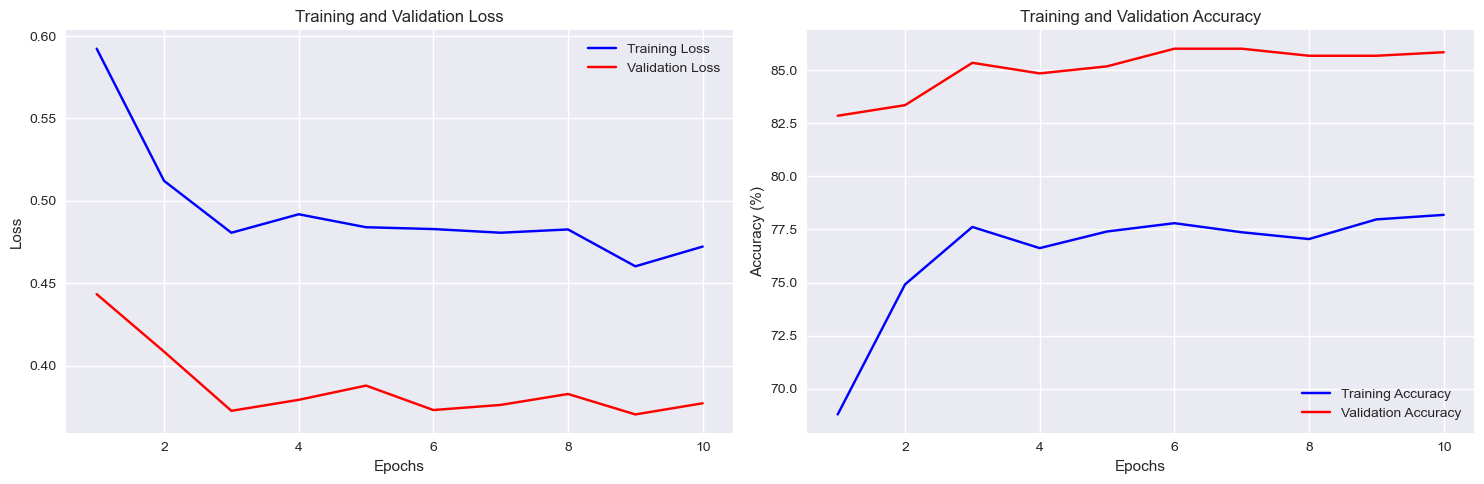


Evaluating model on test set...


Evaluating: 100%|██████████| 19/19 [01:01<00:00,  3.26s/it]


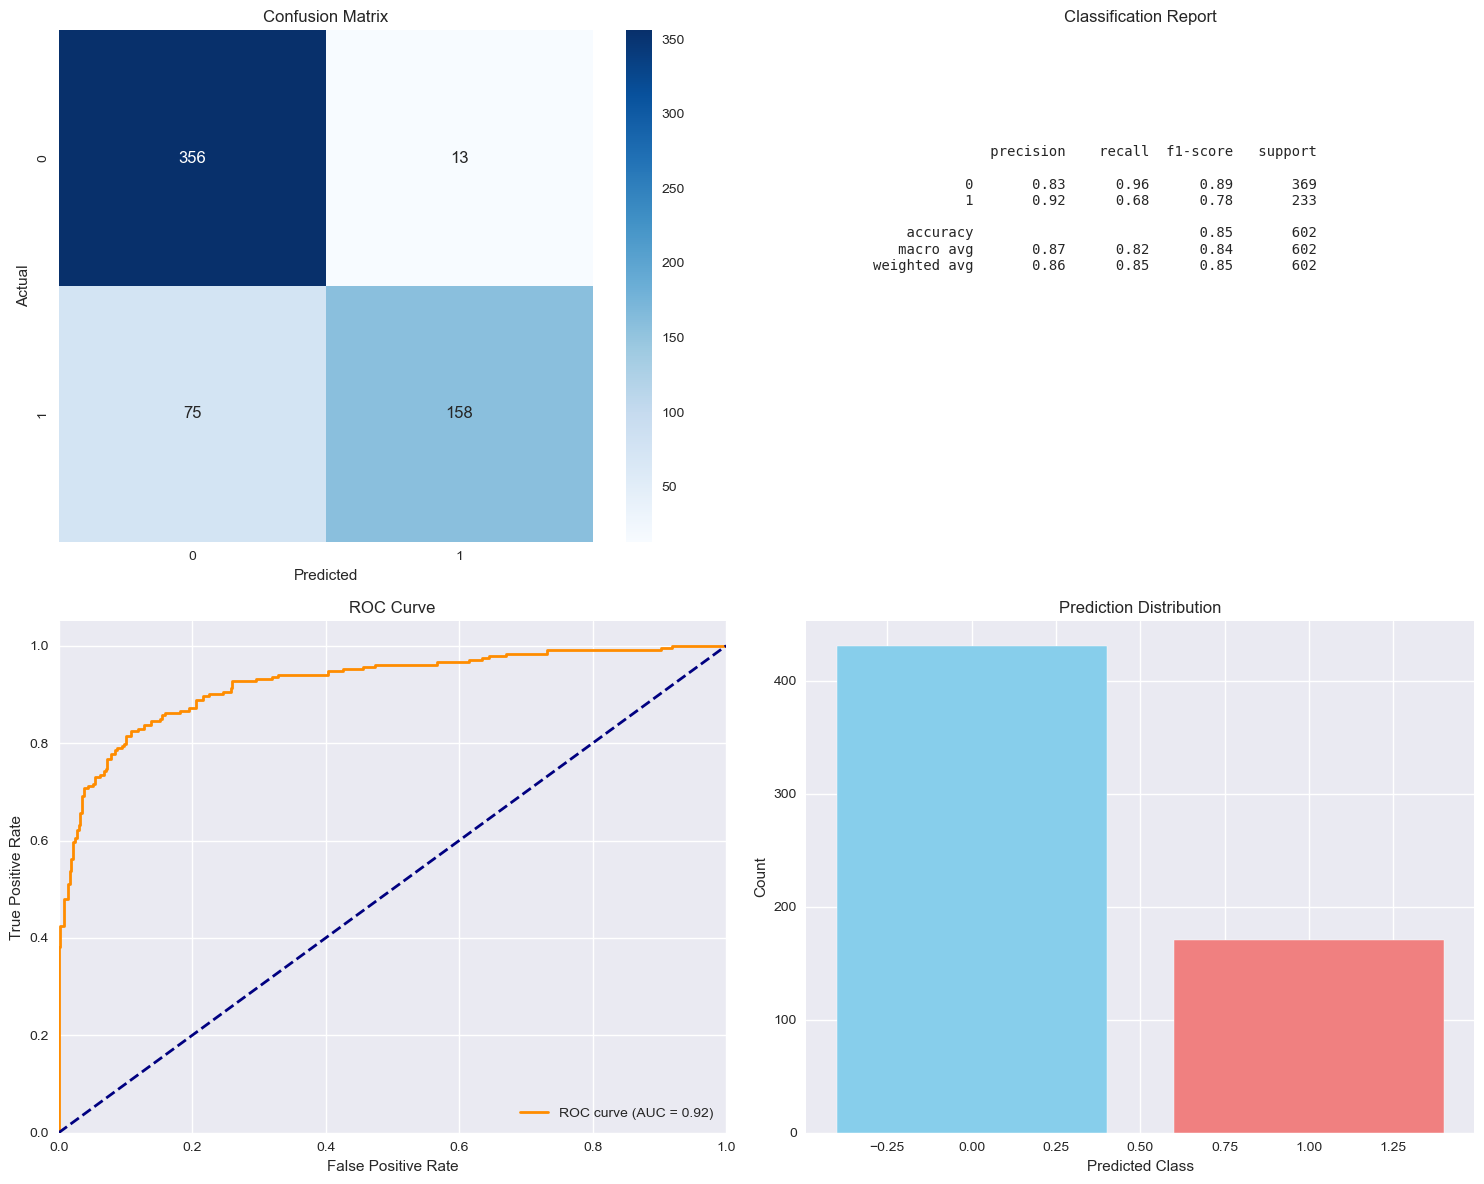


Test Accuracy: 0.8538 (85.38%)
Total test samples: 602
Correctly classified: 514
Misclassified: 88

Model saved as 'medical_image_classifier.pth'

Training and evaluation completed!


In [1]:
# Medical Image Classification with PyTorch
# Complete implementation with visualizations and analysis

import os
import zipfile
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision import models

# Set style for better plots
sns.set_context('notebook')
sns.set_style('white')
plt.style.use('seaborn-v0_8')

# Configuration
class Config:
    BATCH_SIZE = 32
    LEARNING_RATE = 3e-4
    NUM_EPOCHS = 10
    NUM_CLASSES = 2
    IMG_SIZE = 224
    NUM_WORKERS = 0
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f"Using device: {Config.DEVICE}")

# Data preprocessing and normalization values (ImageNet standards)
MEAN = [0.485, 0.456, 0.406]
STD = [0.229, 0.224, 0.225]

def download_file(url, filename):
    """Download file from URL"""
    import urllib.request
    print(f"Downloading {filename}...")
    try:
        urllib.request.urlretrieve(url, filename)
        print(f"✓ Downloaded {filename}")
        return True
    except Exception as e:
        print(f"✗ Failed to download {filename}: {e}")
        return False

def setup_data():
    """Download and extract dataset"""
    # URLs for the dataset
    labels_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/labels.csv"
    data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-GPXX0W5QEN/data/data_sample.zip"
    
    # Download labels.csv if not exists
    if not os.path.exists("labels.csv"):
        if not download_file(labels_url, "labels.csv"):
            raise FileNotFoundError("Failed to download labels.csv")
    
    # Download data_sample.zip if not exists
    if not os.path.exists("data_sample.zip"):
        if not download_file(data_url, "data_sample.zip"):
            raise FileNotFoundError("Failed to download data_sample.zip")
    
    # Extract images from zip file
    if os.path.exists("data_sample.zip"):
        print("Extracting images...")
        with zipfile.ZipFile("data_sample.zip", "r") as zip_ref:
            # List all files in the zip to understand structure
            file_list = zip_ref.namelist()
            print(f"Found {len(file_list)} files in zip")
            
            # Extract all files
            for file in tqdm(file_list, desc="Extracting images"):
                zip_ref.extract(file, ".")
        
        # Check what was actually extracted and find the correct path
        possible_paths = [
            "data_sample/data_sample",
            "data_sample", 
            "./data_sample",
            "./data_sample/data_sample"
        ]
        
        actual_image_path = None
        for path in possible_paths:
            if os.path.exists(path) and os.path.isdir(path):
                files_in_path = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png','.tif', '.tiff'))]
                if files_in_path:
                    actual_image_path = path
                    print(f"✓ Found {len(files_in_path)} images in: {path}")
                    break
        
        if not actual_image_path:
            # List all directories to help debug
            print("Available directories after extraction:")
            for root, dirs, files in os.walk("."):
                if any(f.lower().endswith(('.jpg', '.jpeg', '.png','.tif', '.tiff')) for f in files):
                    print(f"  {root}: {len([f for f in files if f.lower().endswith(('.jpg', '.jpeg', '.png','.tif', '.tiff'))])} images")
        
        # Clean up unwanted files
        for root, dirs, files in os.walk("."):
            for file in files:
                if file == ".DS_Store":
                    os.remove(os.path.join(root, file))
        
        print("✓ Extraction completed")
        return actual_image_path
    
    return None

class MedicalImageDataset(Dataset):
    """Custom dataset for medical images"""
    
    def __init__(self, data_dir, transform=None, dataset_type="full", image_path=None):
        self.data_dir = data_dir
        self.transform = transform
        
        # Set paths - use provided image_path if available
        if image_path and os.path.exists(image_path):
            self.images_path = image_path
        else:
            # Try to find the correct path
            possible_paths = [
                os.path.join(data_dir, "data_sample/data_sample"),
                os.path.join(data_dir, "data_sample"),
                "data_sample/data_sample",
                "data_sample"
            ]
            
            self.images_path = None
            for path in possible_paths:
                if os.path.exists(path) and os.path.isdir(path):
                    files_in_path = [f for f in os.listdir(path) if f.lower().endswith(('.jpg', '.jpeg', '.png','.tif', '.tiff'))]
                    if files_in_path:
                        self.images_path = path
                        break
            
            if not self.images_path:
                raise FileNotFoundError(f"Could not find images directory. Tried: {possible_paths}")
        
        self.labels_path = os.path.join(data_dir, "labels.csv")
        
        # Load labels
        if not os.path.exists(self.labels_path):
            raise FileNotFoundError(f"Labels file not found: {self.labels_path}")
        
        self.labels_df = pd.read_csv(self.labels_path)
        self.labels_df.set_index("id", inplace=True)
        
        # Check if images directory exists
        if not os.path.exists(self.images_path):
            raise FileNotFoundError(f"Images directory not found: {self.images_path}")
        
        # Get all filenames
        all_filenames = [f for f in os.listdir(self.images_path) if f.lower().endswith(('.jpg', '.png', '.jpeg','.tif', '.tiff'))]
        if not all_filenames:
            raise FileNotFoundError(f"No image files found in: {self.images_path}")
        all_filenames.sort()  # Ensure consistent ordering
        
        # Split dataset based on type
        total_files = len(all_filenames)
        train_end = int(0.7 * total_files)
        val_end = int(0.85 * total_files)
        
        if dataset_type == "train":
            self.filenames = all_filenames[:train_end]
        elif dataset_type == "val":
            self.filenames = all_filenames[train_end:val_end]
        elif dataset_type == "test":
            self.filenames = all_filenames[val_end:]
        else:
            self.filenames = all_filenames
        
        print(f"Loaded {dataset_type} dataset with {len(self.filenames)} images from {self.images_path}")
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image_path = os.path.join(self.images_path, filename)
        
        # Load and transform image
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        
        # Get label
        image_id = filename.split('.')[0]
        try:
            label = self.labels_df.loc[image_id, 'label']
        except KeyError:
            # If image ID not found in labels, assign default label
            print(f"Warning: Image ID {image_id} not found in labels, assigning label 0")
            label = 0
        
        return image, label

def create_transforms():
    """Create data transformations"""
    train_transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(degrees=10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])
    
    val_test_transform = transforms.Compose([
        transforms.Resize((Config.IMG_SIZE, Config.IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(MEAN, STD)
    ])
    
    return train_transform, val_test_transform

def visualize_data_distribution(labels_df):
    """Visualize the distribution of labels"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Count plot
    label_counts = labels_df['label'].value_counts()
    axes[0].bar(label_counts.index, label_counts.values, color=['skyblue', 'lightcoral'])
    axes[0].set_title('Distribution of Labels')
    axes[0].set_xlabel('Label')
    axes[0].set_ylabel('Count')
    
    # Pie chart
    axes[1].pie(label_counts.values, labels=label_counts.index, autopct='%1.1f%%', 
                colors=['skyblue', 'lightcoral'])
    axes[1].set_title('Label Distribution (Percentage)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Dataset Statistics:")
    print(f"Total images: {len(labels_df)}")
    print(f"Label distribution:\n{label_counts}")
    print(f"Class balance ratio: {label_counts.min() / label_counts.max():.2f}")

def visualize_sample_images(dataset, num_samples=12):
    """Visualize sample images from the dataset"""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Denormalize image for display
        image_np = image.numpy().transpose((1, 2, 0))
        image_np = np.array(STD) * image_np + np.array(MEAN)
        image_np = np.clip(image_np, 0, 1)
        
        axes[i].imshow(image_np)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    
    plt.suptitle('Sample Images from Dataset', fontsize=16)
    plt.tight_layout()
    plt.show()

class ResNetClassifier(nn.Module):
    """ResNet-based classifier for medical images"""
    
    def __init__(self, num_classes=2, pretrained=True):
        super(ResNetClassifier, self).__init__()
        
        # Load pretrained ResNet34
        self.backbone = models.resnet34(pretrained=pretrained)
        
        # Freeze backbone parameters
        for param in self.backbone.parameters():
            param.requires_grad = False
        
        # Replace final layer
        num_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )
        
        # Unfreeze final layers for fine-tuning
        for param in self.backbone.fc.parameters():
            param.requires_grad = True
    
    def forward(self, x):
        return self.backbone(x)

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    """Train the model with validation"""
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    
    model.to(Config.DEVICE)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        
        train_pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')
        for batch_idx, (inputs, labels) in enumerate(train_pbar):
            inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
            
            # Update progress bar
            train_pbar.set_postfix({
                'Loss': f'{running_loss/(batch_idx+1):.4f}',
                'Acc': f'{100.*correct_train/total_train:.2f}%'
            })
        
        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = 100. * correct_train / total_train
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        
        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = 100. * correct_val / total_val
        
        # Store metrics
        train_losses.append(epoch_train_loss)
        val_losses.append(epoch_val_loss)
        train_accuracies.append(epoch_train_acc)
        val_accuracies.append(epoch_val_acc)
        
        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%')
        print(f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%')
        print('-' * 50)
    
    return train_losses, val_losses, train_accuracies, val_accuracies

def plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies):
    """Plot training and validation metrics"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    epochs = range(1, len(train_losses) + 1)
    
    # Plot losses
    ax1.plot(epochs, train_losses, 'b-', label='Training Loss')
    ax1.plot(epochs, val_losses, 'r-', label='Validation Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True)
    
    # Plot accuracies
    ax2.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
    ax2.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()

def evaluate_model(model, test_loader):
    """Comprehensive model evaluation"""
    model.eval()
    model.to(Config.DEVICE)
    
    all_predictions = []
    all_labels = []
    all_probabilities = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(Config.DEVICE), labels.to(Config.DEVICE)
            outputs = model(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probabilities.extend(probabilities.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels), np.array(all_probabilities)

def plot_evaluation_metrics(predictions, labels, probabilities):
    """Plot comprehensive evaluation metrics"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Confusion Matrix
    cm = confusion_matrix(labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted')
    axes[0,0].set_ylabel('Actual')
    
    # Classification Report (as text)
    report = classification_report(labels, predictions, output_dict=True)
    report_text = classification_report(labels, predictions)
    axes[0,1].text(0.1, 0.5, report_text, fontsize=10, family='monospace')
    axes[0,1].set_title('Classification Report')
    axes[0,1].axis('off')
    
    # ROC Curve
    if probabilities.shape[1] == 2:  # Binary classification
        fpr, tpr, _ = roc_curve(labels, probabilities[:, 1])
        roc_auc = auc(fpr, tpr)
        axes[1,0].plot(fpr, tpr, color='darkorange', lw=2, 
                      label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[1,0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[1,0].set_xlim([0.0, 1.0])
        axes[1,0].set_ylim([0.0, 1.05])
        axes[1,0].set_xlabel('False Positive Rate')
        axes[1,0].set_ylabel('True Positive Rate')
        axes[1,0].set_title('ROC Curve')
        axes[1,0].legend(loc="lower right")
        axes[1,0].grid(True)
    
    # Prediction distribution
    unique_labels, counts = np.unique(predictions, return_counts=True)
    axes[1,1].bar(unique_labels, counts, color=['skyblue', 'lightcoral'])
    axes[1,1].set_title('Prediction Distribution')
    axes[1,1].set_xlabel('Predicted Class')
    axes[1,1].set_ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed metrics
    accuracy = np.mean(predictions == labels)
    print(f"\nTest Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"Total test samples: {len(labels)}")
    print(f"Correctly classified: {np.sum(predictions == labels)}")
    print(f"Misclassified: {np.sum(predictions != labels)}")

def create_demo_data():
    """Create demo data for testing if real data is not available"""
    print("Creating demo data for testing...")
    
    # Create demo labels
    demo_labels = pd.DataFrame({
        'id': [f'demo_{i:04d}' for i in range(100)],
        'label': np.random.choice([0, 1], 100)
    })
    demo_labels.to_csv('demo_labels.csv', index=False)
    
    # Create demo images directory
    demo_dir = "demo_data/demo_data"
    os.makedirs(demo_dir, exist_ok=True)
    
    # Create dummy images (random noise)
    for i in range(100):
        # Create a random RGB image
        img_array = np.random.randint(0, 255, (224, 224, 3), dtype=np.uint8)
        img = Image.fromarray(img_array)
        img.save(f"{demo_dir}/demo_{i:04d}.jpg")
    
    print("✓ Demo data created")
    return demo_dir, 'demo_labels.csv'

def main():
    """Main training and evaluation pipeline"""
    print("Medical Image Classification with PyTorch")
    print("=" * 50)
    
    # Try to setup real data first
    try:
        print("Setting up real data...")
        setup_data()
        data_dir = "./"
        labels_file = "labels.csv"
        use_demo = False
    except Exception as e:
        print(f"Failed to setup real data: {e}")
        print("Falling back to demo data...")
        demo_dir, labels_file = create_demo_data()
        data_dir = "."
        use_demo = True
    
    # Load and visualize dataset information
    print("\nAnalyzing dataset...")
    if os.path.exists("labels.csv"):
        labels_df = pd.read_csv("labels.csv")
        print(f"Dataset loaded with {len(labels_df)} images")
        visualize_data_distribution(labels_df)
    else:
        print("Warning: labels.csv not found. Skipping data distribution analysis.")
    # Create transforms
    train_transform, val_test_transform = create_transforms()
    
    # Create datasets
    data_dir = "./"
    try:
        train_dataset = MedicalImageDataset(data_dir, train_transform, "train")
        val_dataset = MedicalImageDataset(data_dir, val_test_transform, "val")
        test_dataset = MedicalImageDataset(data_dir, val_test_transform, "test")
    except FileNotFoundError as e:
        print(f"Error creating datasets: {e}")
        print("Please ensure the data has been downloaded and extracted properly.")
        return
    
    # Visualize sample images
    print("\nVisualizing sample images...")
    visualize_sample_images(train_dataset)
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, 
                             shuffle=True, num_workers=Config.NUM_WORKERS)
    val_loader = DataLoader(val_dataset, batch_size=Config.BATCH_SIZE, 
                           shuffle=False, num_workers=Config.NUM_WORKERS)
    test_loader = DataLoader(test_dataset, batch_size=Config.BATCH_SIZE, 
                            shuffle=False, num_workers=Config.NUM_WORKERS)
    
    # Create model
    print(f"\nCreating model...")
    model = ResNetClassifier(num_classes=Config.NUM_CLASSES)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=Config.LEARNING_RATE)
    
    print(f"Model created with {sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable parameters")
    
    # Train model
    print(f"\nTraining model for {Config.NUM_EPOCHS} epochs...")
    train_losses, val_losses, train_accuracies, val_accuracies = train_model(
        model, train_loader, val_loader, criterion, optimizer, Config.NUM_EPOCHS
    )
    
    # Plot training history
    plot_training_history(train_losses, val_losses, train_accuracies, val_accuracies)
    
    # Evaluate model
    print("\nEvaluating model on test set...")
    predictions, labels, probabilities = evaluate_model(model, test_loader)
    plot_evaluation_metrics(predictions, labels, probabilities)
    
    # Save model
    torch.save(model.state_dict(), 'medical_image_classifier.pth')
    print("\nModel saved as 'medical_image_classifier.pth'")
    
    print("\nTraining and evaluation completed!")

if __name__ == "__main__":
    main()